# SI671 Final Project

Name: Sijun Tao (sijuntao)

Date: 2023 Dec

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Data Loading & Processing

In [2]:
steam = pd.read_csv("data/steam_games.csv")
game = pd.read_csv("data/games.csv")

#### Merge two dataset and drop the useless columns

In [3]:
df = pd.merge(steam, game, left_on = "ID", right_on = "AppID", how = "inner")
drop_list = ["Unnamed: 0", "AppID", "labels", "Name", "Price", "Notes", "Support url", "Support email", "Windows", "Mac", "Linux", "Peak CCU", "Screenshots", "Movies", "Developers"]
df = df.drop(columns = drop_list)

#### Process the genres, categories, and tags of games

In [4]:
df.columns = df.columns.str.lower()
df = df.fillna(0)
df["genres"] = df["genres"].str.split(',')
df["categories"] = df["categories"].str.split(',')
df["tags"] = df["tags"].str.split(',')
df = df.dropna(subset=['tags', 'genres', 'categories'])
df["tags"] = df["tags"].apply(lambda x: x[:5])

#### Use midpoint to estimate the number of owners

In [5]:
def convert_to_midpoint(range_str):
    lower, upper = map(int, range_str.split(' - '))
    midpoint = (lower + upper) / 2
    return midpoint

df['estimated owners mid'] = df['estimated owners'].apply(convert_to_midpoint)

In [6]:
df.head()

,id,name,price,developers,num_reviews,positive_review_rate,release date,estimated owners,required age,dlc count,...,recommendations,average playtime forever,average playtime two weeks,median playtime forever,median playtime two weeks,publishers,categories,genres,tags,estimated owners mid
0,1794930,EGG FLY,4.99,Egg Shell Studio,4,1.000000,"Feb 4, 2022",0 - 20000,0,0,...,0,0,0,0,0,Egg Shell Studio,[Single-player],"[Casual, Indie]","[2D Platformer, Puzzle-Platformer, Physics, Si...",10000.0
1,895430,From The Sky: New Horizon,0.99,Valkyrie,45,0.155556,"Aug 2, 2018",0 - 20000,0,0,...,0,0,0,0,0,Valkyrie Games,"[Single-player, Steam Achievements]","[Adventure, Casual, Indie]","[Casual, Indie, Adventure, Female Protagonist,...",10000.0
2,746910,Chicken Farm 2K17,0.00,Jakal Studios,300,0.770000,"Dec 5, 2017",50000 - 100000,0,1,...,0,17,0,28,0,Jakal Studios,[Single-player],"[Casual, Free to Play, Indie, Simulation, Stra...","[Free to Play, Clicker, Indie, Casual, Strategy]",75000.0
4,235980,Tetrobot and Co.,9.99,Swing Swing Submarine,457,0.971554,"Oct 22, 2013",50000 - 100000,0,1,...,240,129,0,194,0,Swing Swing Submarine,"[Single-player, Steam Achievements, Full contr...","[Casual, Indie]","[Puzzle, Indie, Casual, Robots, Difficult]",75000.0
5,433570,Side Quest,6.99,Miris Mind,12,0.666667,"Feb 15, 2016",0 - 20000,0,0,...,0,0,0,0,0,Miris Mind,"[Single-player, Steam Achievements, Full contr...","[Action, Adventure, Indie]","[Adventure, Action, Indie]",10000.0


## Define Popularity

To define which game can be considered as popular, we use a combination of factors. A weighted sum approach is applied here:

$$
\text{Popularity}=\sum_{i=1}^n w_i \times f_i,
$$

where $w_i$ is the weight of the factor and $f_i$ is the $i^{th}$ factor.

In this scenario, we will mainly use five factors: `num_reviews`, `estimated owners mid`, `recommendations`, `user score`, and `average playtime forever`. The weights are given as follows and the reasons are described:
- `num_reviews` has a weight of **0.25**. It is relatively important as it can directly reveal how many players play this game and comment on it.
- `estimated owners mid` has a weight of **0.4**. It is very important since it reveals the actual number of players of this game.
- `recommendations` has a weight of **0.2**. This is also important because the number of recommendations gives new players an immediate judgment and attracts new players to play.
- `user score` has a weight of **0.05**. This is not that important since the score is a subjective assessment.
- `average playtime forever` has a weight of **0.1**. It kind of shows whether the game is appealing and popular.

#### Normalize the factors

In [7]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['num_reviews', 'estimated owners mid', 'recommendations', 'user score', 'average playtime forever']

# MinMaxScaler
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

#### Calculate the popularity

In [8]:
weights = {'num_reviews': 0.25, 'estimated owners mid': 0.4, 'recommendations': 0.2, 'user score': 0.05, 'average playtime forever': 0.1}
df['popularity'] = (df[columns_to_normalize] * list(weights.values())).sum(axis=1)

In [9]:
df.head()

,id,name,price,developers,num_reviews,positive_review_rate,release date,estimated owners,required age,dlc count,...,average playtime forever,average playtime two weeks,median playtime forever,median playtime two weeks,publishers,categories,genres,tags,estimated owners mid,popularity
0,1794930,EGG FLY,4.99,Egg Shell Studio,6.124545e-07,1.000000,"Feb 4, 2022",0 - 20000,0,0,...,0.000000,0,0,0,Egg Shell Studio,[Single-player],"[Casual, Indie]","[2D Platformer, Puzzle-Platformer, Physics, Si...",0.000000,1.531136e-07
1,895430,From The Sky: New Horizon,0.99,Valkyrie,6.890114e-06,0.155556,"Aug 2, 2018",0 - 20000,0,0,...,0.000000,0,0,0,Valkyrie Games,"[Single-player, Steam Achievements]","[Adventure, Casual, Indie]","[Casual, Indie, Adventure, Female Protagonist,...",0.000000,1.722528e-06
2,746910,Chicken Farm 2K17,0.00,Jakal Studios,4.593409e-05,0.770000,"Dec 5, 2017",50000 - 100000,0,1,...,0.000188,0,28,0,Jakal Studios,[Single-player],"[Casual, Free to Play, Indie, Simulation, Stra...","[Free to Play, Clicker, Indie, Casual, Strategy]",0.000433,2.036439e-04
4,235980,Tetrobot and Co.,9.99,Swing Swing Submarine,6.997293e-05,0.971554,"Oct 22, 2013",50000 - 100000,0,1,...,0.001428,0,194,0,Swing Swing Submarine,"[Single-player, Steam Achievements, Full contr...","[Casual, Indie]","[Puzzle, Indie, Casual, Robots, Difficult]",0.000433,3.475617e-04
5,433570,Side Quest,6.99,Miris Mind,1.837364e-06,0.666667,"Feb 15, 2016",0 - 20000,0,0,...,0.000000,0,0,0,Miris Mind,"[Single-player, Steam Achievements, Full contr...","[Action, Adventure, Indie]","[Adventure, Action, Indie]",0.000000,4.593409e-07


## 1. Frequent Tags Sets in Popular Games

### 1.1 Explore on the frequent tags combinations

In [10]:
popular_df = df[df['popularity'] > 0.005]

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags_matrix = mlb.fit_transform(popular_df['tags'])
tags_matrix = pd.DataFrame(tags_matrix, columns=mlb.classes_)
tags_matrix

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,4 Player Local,...,War,Wargame,Warhammer 40K,Web Publishing,Western,Word Game,World War I,World War II,Zombies,e-sports
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Use Apriori algorithm

In [14]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def tags_frequent_itemsets(tags_matrix, k, min_support):
    tags_matrix = tags_matrix.astype(bool)
    frequent_itemsets = apriori(tags_matrix, min_support=min_support, use_colnames=True)
    frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == k]  
    return frequent_itemsets

In [15]:
tags_frequent_itemsets(tags_matrix, 5, 0.003)

,support,itemsets
1434,0.003643,"(Parkour, Adventure, Action, Open World, Stealth)"
1435,0.003643,"(Singleplayer, Third Person, Action, Assassin,..."
1436,0.008197,"(First-Person, Action, FPS, Shooter, Multiplayer)"
1437,0.008197,"(Free to Play, Action, FPS, Shooter, Multiplayer)"
1438,0.004554,"(Action, Zombies, FPS, Shooter, Multiplayer)"
1439,0.004554,"(Racing, Automobile Sim, Simulation, Multiplay..."
1440,0.003643,"(Team-Based, FPS, Tactical, Shooter, Multiplayer)"


### 1.2 Explore on the frequent single tags

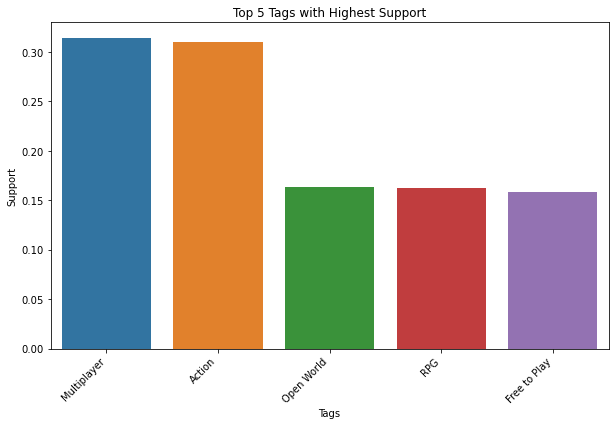

In [16]:
result = tags_frequent_itemsets(tags_matrix, 1, 0.03)
result = result.sort_values(by = ['support'], ascending=False)
top_items = result.head(5)
top_items['itemsets'] = top_items['itemsets'].apply(lambda x: ', '.join(map(str, x)))

plt.figure(figsize=(10, 6))
sns.barplot(x=top_items['itemsets'].astype(str), y=top_items['support'])
plt.xlabel('Tags')
plt.ylabel('Support')
plt.title('Top 5 Tags with Highest Support')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

## 2. Features Analysis 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score


label_encoder = LabelEncoder()
df["developers"] = df["developers"].astype(str)
df["publishers"] = df["publishers"].astype(str)
df['developer_encoded'] = label_encoder.fit_transform(df['developers'])
df['publisher_encoded'] = label_encoder.fit_transform(df['publishers'])

features = ['price', 'positive_review_rate', 'developer_encoded', 'required age', 'dlc count', 'metacritic score', 'positive','negative', 'score rank', 'achievements', 'publisher_encoded']
target = 'popularity' 

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### Choose the best model

In [20]:
# Train RandomForestRegressor
rf_model = RandomForestRegressor(random_state = 0)
rf_model.fit(X_train, y_train)
rf_feature_importances = rf_model.feature_importances_
print("R2 of Random Forest Model: ", r2_score(y_test, rf_model.predict(X_test)))
print("MSE of Random Forest Model: ", mean_squared_error(y_test, rf_model.predict(X_test)))

R2 of Random Forest Model:  0.8245239838663685
MSE of Random Forest Model:  7.430047936231553e-06


In [21]:
# Train XGBoostRegressor
xgb_model = XGBRegressor(random_state = 0)
xgb_model.fit(X_train, y_train)
xbg_feature_importances = xgb_model.feature_importances_
print("R2 of XGBoost Model: ", r2_score(y_test, xgb_model.predict(X_test)))
print("MSE of XGBoost Model: ", mean_squared_error(y_test, xgb_model.predict(X_test)))

R2 of XGBoost Model:  0.4889466284434085
MSE of XGBoost Model:  2.163914552144014e-05


In [22]:
# Train GradientBoostingRegressor
gbm_model = GradientBoostingRegressor(random_state = 0)
gbm_model.fit(X_train, y_train)
gbm_feature_importances = gbm_model.feature_importances_
print("R2 of Gradient Boost Model: ", r2_score(y_test, gbm_model.predict(X_test)))
print("MSE of Gradient Boost Model: ", mean_squared_error(y_test, gbm_model.predict(X_test)))

R2 of Gradient Boost Model:  0.8078886447427791
MSE of Gradient Boost Model:  8.134425490766473e-06


#### Visualize the feature importance

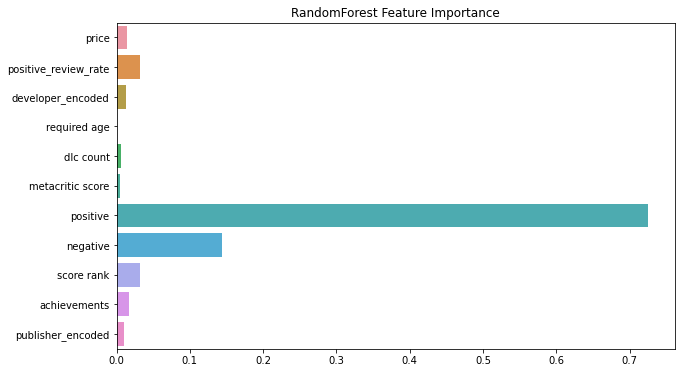

In [23]:
# Visualize feature importance for RandomForest
plt.figure(figsize=(10, 6))

# RandomForest
sns.barplot(y=features, x=rf_feature_importances)

plt.title('RandomForest Feature Importance')
plt.show()

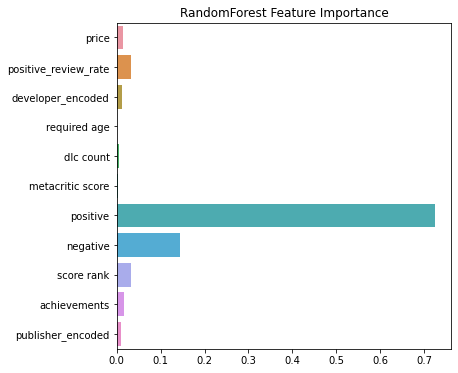

In [40]:
plt.figure(figsize=(6, 6))
sns.barplot(y=features, x=rf_feature_importances)

plt.title('RandomForest Feature Importance')
plt.show()

In [25]:
print(rf_feature_importances)
print(features)

[0.01392453 0.03168462 0.01285693 0.00100431 0.00664672 0.00431613
 0.72523346 0.14392239 0.03243291 0.01744731 0.01053068]
['price', 'positive_review_rate', 'developer_encoded', 'required age', 'dlc count', 'metacritic score', 'positive', 'negative', 'score rank', 'achievements', 'publisher_encoded']


## 3. Time Analysis 

### 3.1 Explore the appropriate release month

In [26]:
month_to_number = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
df['month'] = df['release date'].str[:3]
df['month'] = df['month'].map(month_to_number)

popularity_threshold = 0.005
df['is popular'] = df['popularity'] > popularity_threshold
monthly_release_count = df.groupby('month')['is popular'].value_counts().unstack().fillna(0)

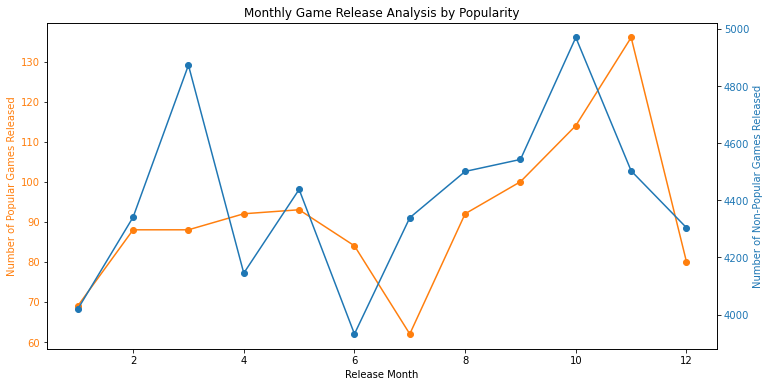

In [27]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# first y-axis on the left for popular games
color = 'tab:orange'
ax1.set_xlabel('Release Month')
ax1.set_ylabel('Number of Popular Games Released', color=color)
ax1.plot(monthly_release_count.index, monthly_release_count[True], label='Popular', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# second y-axis on the right for non-popular games
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Non-Popular Games Released', color=color)
ax2.plot(monthly_release_count.index, monthly_release_count[False], label='Not Popular', marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Game Release Analysis by Popularity')
plt.show()


### 3.2 Explore the game release trend and time pattern

In [28]:
df["year"] = df['release date'].str[-4:].astype(int)
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m')

time_df = df[(df["year"] >= 2014) & (df["year"] <= 2021)]
game_per_month = time_df.groupby("date")[['id']].count().rename(columns = {"id": "cnt"})

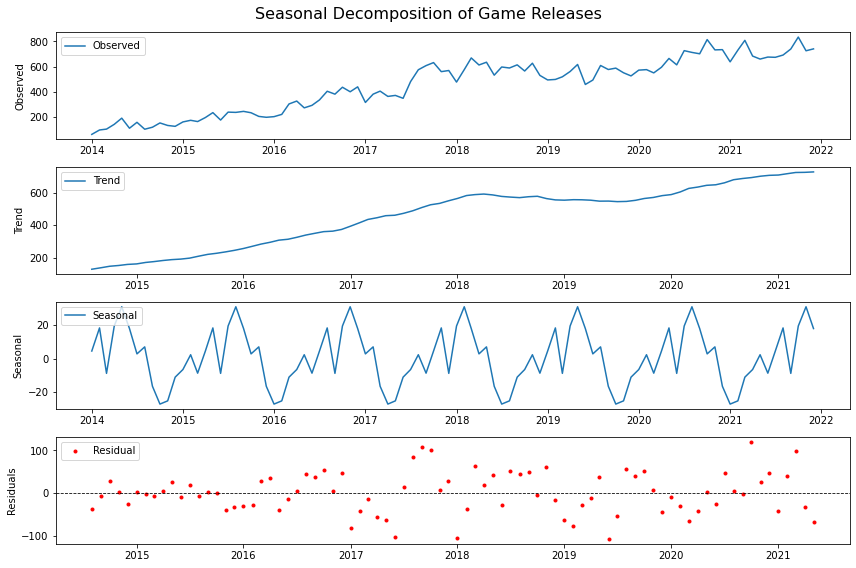

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(game_per_month["cnt"], model='additive', period=15)  # Assuming a seasonal period of 12 months

plt.figure(figsize=(12, 8))
plt.suptitle('Seasonal Decomposition of Game Releases', fontsize=16)

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.ylabel('Observed')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.scatter(game_per_month.index, result.resid, label='Residual', color='red', marker='.')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Add a horizontal line at y=0 for reference
plt.legend(loc='upper left')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
